# Separate building edges from text within bounding boxes
This script separates text from building edges which are still within the bounding boxes exported by Strabo. The aim is to eliminate text but no building edge from the input map (see paper section 4.1) for an improved subsequent object extraction. By eliminating text - which, in general, has similar gray values and sometimes even overlaps with other map features (e.g. buildings) - from the input image, the segmentation of buildings and other objects is facilitated.<br>

The bounding box of each label is "reduced" by the building edges so that the bounding box only contains text in the end.

In [1]:
import cv2
import geopandas as gpd
import math
import numpy as np
import os
import rasterio
import re
import shapely

from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from osgeo import gdal, ogr
from PIL import Image
from rasterio.plot import show
from skimage import io
from skimage.color import rgb2hsv
from scipy.misc import imsave

In [2]:
%matplotlib inline
shapely.speedups.disable()

# 1) Prepare data
## 1.1) Define input

In [3]:
path = "data\\"
inputname = "ID_1.tif"

## 1.2) Create output

In [4]:
outfolder_1 = inputname.replace('_Clip', '')
outfolder_1 = outfolder_1.replace('.tif', '')
outfolder = "data/output/" + outfolder_1

if not os.path.exists(outfolder): # if it does not exist yet...
    os.makedirs(outfolder) # ...create new folder in directory to save the centroids in it

## 1.3) Import image

C:\Users\schlegel\Anaconda3\lib\site-packages\rasterio\__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


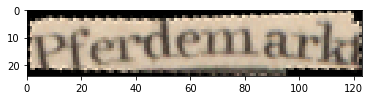

In [5]:
# plot raster
inputtif = rasterio.open(path + inputname)
show(inputtif.read(), transform=inputtif.transform)

## 1.4) Read metadata

In [6]:
inputtif_gdal = gdal.Open(path + inputname)
ulx, xres, xskew, uly, yskew, yres  = inputtif_gdal.GetGeoTransform()

# if upper left corner = 0.0 0.0: read it from the corresponding BB

if ulx == 0 and uly == 0:   
    
    boundingboxes = gpd.read_file("data/input/improved_boundingboxes_strabo_wgs84.shp")
    boundingboxes = boundingboxes.sort_values(by=['id'])
    
    idnumber = inputname.replace('ID_','')
    idnumber = idnumber.replace('.tif','')
    idx = int(idnumber)
    
    centroidx = float(boundingboxes['centroid_x'].loc[boundingboxes.id == idx].astype(float, errors = 'raise'))
    centroidy = float(boundingboxes['centroid_y'].loc[boundingboxes.id == idx].astype(float, errors = 'raise'))
    
    if math.isnan(centroidx):
        centroidx = float(boundingboxes['geometry'].loc[boundingboxes.id == idx].centroid.x)
    
    if math.isnan(centroidy):
        centroidy = float(boundingboxes['geometry'].loc[boundingboxes.id == idx].centroid.y)

    if yres > 0:
        yres = yres * (-1)

    print("Centroid:", centroidx, centroidy,
          "\nPixel resolution:", xres, yres,
          "\nRotation:", float(boundingboxes['inclinatio'].loc[boundingboxes.id == idx].astype(float, errors = 'raise'))
         )

else:
    
    # crs with corner coordinates for later use
    lrx = ulx + (inputtif_gdal.RasterXSize * xres)
    lry = uly + (inputtif_gdal.RasterYSize * yres)
    
    print("Upper left corner:", ulx, uly, 
          "\nPixel Resolution:", xres, yres, 
          "\nRotation:", xskew, yskew, 
          "\nDimensions:", lrx, lry)

Centroid: 913.4413503092584 -197.0454564918782 
Pixel resolution: 1.0 -1.0 
Rotation: 75.98736233333334


In [7]:
# # check number of bands
# inputtif.count

## 1.4) Convert to grayscales
This is done by OpenCV as follows:<br>
R * 0.299 + G * 0.587 + B * 0.114

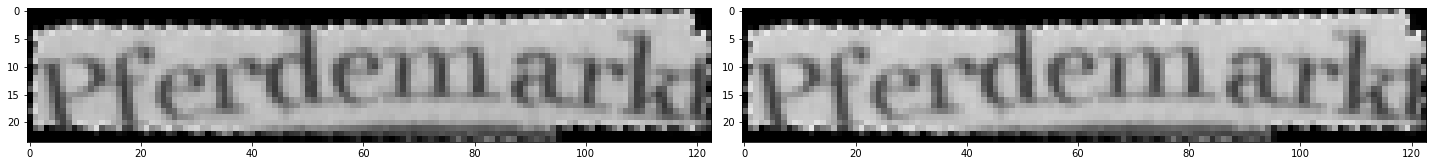

In [8]:
# method 1: load image directely in grayscale mode
gray_cv2_1 = cv2.imread(path+inputname, 0)

# method 2: load original image and convert it to grayscales afterwards
img = cv2.imread(path+inputname)
gray_cv2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# visual comparison of both methods
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(cv2.cvtColor(gray_cv2_1, cv2.COLOR_BGR2RGB))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(cv2.cvtColor(gray_cv2, cv2.COLOR_BGR2RGB))
fig.tight_layout()

We choose method 2 to avoid errors and uncertainties within the import in grayscale mode.

In [9]:
# export grayscale image to PNG
graypng = Image.fromarray(gray_cv2)
grayscalename = outfolder_1 + '_grayscale_cv2.png'
imsave(outfolder + '/' + grayscalename, graypng)

C:\Users\schlegel\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


## 1.5) Convert to HSL
to visually check the Value channel which may be an alternative to grayscale

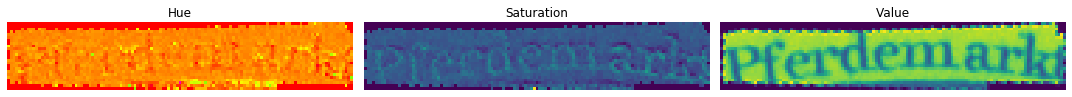

In [10]:
rgb = io.imread(path+inputname)
hsv_img = rgb2hsv(rgb)
hue_img = hsv_img[:, :, 0]
saturation_img = hsv_img[:, :, 1]
value_img = hsv_img[:, :, 2]

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 8))

ax0.imshow(hue_img, cmap='hsv')
ax0.set_title("Hue")
ax0.axis('off')
ax1.imshow(saturation_img)
ax1.set_title("Saturation")
ax1.axis('off')
ax2.imshow(value_img)
ax2.set_title("Value")
ax2.axis('off')

fig.tight_layout()

# 2) Reduce Bounding Boxes
In this step, edges of buildings are removed from the bounding boxes containing text image areas.
## 2.1) Create a mask consisting of 3 values
**0 = Background<br>
1 = Text<br>
2 = Building Edge**

### 2.1.1) Make a binary mask
To generate a binary mask, we work on the basis of the grayscale text image image *gray_cv2* generated via OpenCV.<br>
A threshold (here: 150) helps to separate dark *foreground* from bright *background* pixels.

In [11]:
# define output name for binary mask
binaryname = outfolder_1 + '_binarized.png'

In [12]:
# Set threshold to make a binary image
binaryarray = np.where(gray_cv2>150, 0, 1)

# Covert numpy array back to image 
binarypng = Image.fromarray(binaryarray)

# export file
imsave(outfolder + '/' + binaryname, binarypng)

C:\Users\schlegel\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


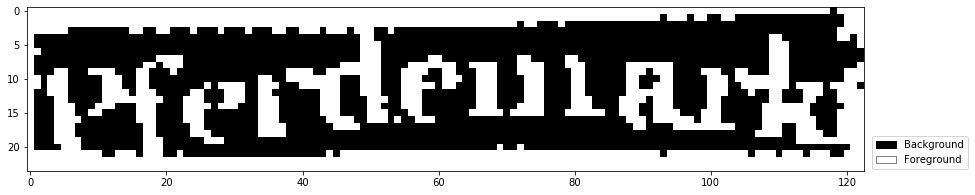

In [48]:
# define output colors for imshow
cmap = ListedColormap(['black','white'])

# enlarge the display of the binary image
fig = plt.figure(figsize = (15,5)) 
ax = fig.add_subplot(111)
imshow(binaryarray, interpolation='none', cmap=cmap)

# add legend
legend_elements = [Patch(facecolor='black', edgecolor='black', label='Background'),
                   Patch(facecolor='white', edgecolor='black', label='Foreground', linewidth=0.5)
                  ]
ax.legend(handles=legend_elements, loc=(1.01,0.01))

plt.show()

**Legend**<br>
0 = white, Background<br>
1 = black, Foreground (Text or building edges)

### 2.1.2) Make a 3-class mask
Separate between text and building edges with multiple conditions.

**Legend**<br>
0 = white, Background<br>
1 = black, Foreground (Text)<br>
2 = black, Foreground (Building edges)

In [49]:
mask = binaryarray.copy()

In [50]:
def repeatingNumbers(numList):
    """
    count consecutive(!) identical values
    """
    i = 0

    while i < len(numList) - 1:
        n = numList[i]
        startIndex = i
        while i < len(numList) - 1 and numList[i] == numList[i + 1]:
            i = i + 1

        endIndex = i
  
        if endIndex-startIndex >= 4 and n == 1:
            
            numList[startIndex] = 2
            numList[endIndex] = 2

            for one in range(startIndex, endIndex):
                numList[one] = 2
              
        i = i + 1

#### Classify building edge pixels within 3-class mask
The following cell applies only for rows at the upper or lower borders (+ ~5 rows) of the input image and in consideration of the following conditions.<br><br>
1) rows consisting **solely** of *foreground* pixels,<br>
2) rows with >30% *foreground* pixels **and** >*threshold* *foreground* pixels side-by-side<br>
3) rows below a complete *building edge* row in the lower part or above a complete *building edge* row in the upper part (from 1) or 2))<br>
4) first or last row with >*threshold* side-by-side *foreground* pixels<br>
5) rows at the upper or lower border consisting solely of *background* and *building edge* pixels (from 1) to 4)) and neighboring to rows containing only *text*

In [51]:
for rowindex, row in enumerate(mask):
    
    # Apply only if the rows are at the upper or lower borders (~5 rows) of the input image.
    # Adjust this threshold if necessary.
    
    if rowindex < 5 or rowindex > (len(mask)-5):   
        
        foregroundpixel_relative = (np.count_nonzero(row == 1) / len(row)) * 100
        backgroundpixel_relative = (np.count_nonzero(row == 0) / len(row)) * 100        

        # 1) if a row consists solely of foreground pixels: this must be a building edge
                        
        if int(foregroundpixel_relative) == 100:
            row[row >= 0] = 2
            print("\nCase 1): row ", rowindex, " has ", int(foregroundpixel_relative), "% foreground pixels:\n", row)

        # 2) if more than 30% of all pixels within a row are black...
        
        if int(foregroundpixel_relative) > 30 and int(foregroundpixel_relative) < 100:
            print("\nCase 2): row ", rowindex, " has ", int(foregroundpixel_relative), "% foreground pixels:", sep="")

            # ...check if there are areas with more than *threshold* foreground pixels side-by-side...
            threshold = 40

            for pixelindex, pixelvalue in zip(range(0, len(row)), row):

                subset = row[pixelindex:pixelindex+threshold]

                if(len(subset)==threshold and all(item == 1 for item in subset)):      

                    # ...and convert those pixels to buildings edges (pixelvalue = 2)
                    repeatingNumbers(row)
            print(row)          

        # 3) Convert the remaining rows below or above a row, which is completely '2', also to '2' (= background)
        # - depending on if the row is in the upper or lower area of the image   

        if np.all((row == 2)):
            
            # 3a) row is in the upper part of the image            
            if rowindex < ((len(mask)-1)/2) and rowindex != 0:
                # convert the remaining rows above the row which is completely '2' also to '2' (= background)
                mask[rowindex-1] = 2
                print("\nCase 3): row ", rowindex, " is below row ", rowindex-1, " which should now also consist completely out of '2':\n", row, sep="")
                    
            # 3b) row is in the lower part of the image
            if rowindex >= ((len(mask)-1)/2) and rowindex != len(mask)-1:
                mask[rowindex+1] = 2
                print("\nCase 3): row ", rowindex, " is above row ", rowindex+1, " which should now also consist completely out of '2':\n", row, sep="")


Case 2): row 0 has 99% foreground pixels:
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 0 1 1 1 1]

Case 2): row 1 has 83% foreground pixels:
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1]

Case 2): row 2 has 63% foreground pixels:
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 1
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1]

Case 2): row 21 has 73% foreground pixels:
[2 2 2 2 2 2 2 2 2 2 2 0 0 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0

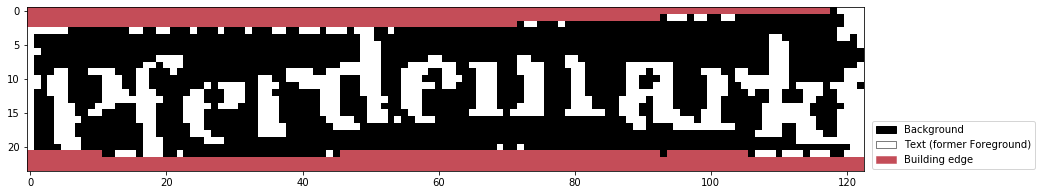

In [54]:
# define new output colors for imshow
cmap = ListedColormap(['black', 'white','#C44D58'])

# plot
fig = plt.figure(figsize = (15,5)) 
ax = fig.add_subplot(111)
imshow(mask, interpolation='none', cmap=cmap)

# add legend
legend_elements = [Patch(facecolor='black', edgecolor='black', label='Background'),
                   Patch(facecolor='white', edgecolor='black', label='Text (former Foreground)', linewidth=0.5),
                   Patch(facecolor='#C44D58', edgecolor='#C44D58', label='Building edge', linewidth=0.5)
                  ]
ax.legend(handles=legend_elements, loc=(1.01,0.01))

plt.show()

In [55]:
# 4) if at least *threshold* foreground pixels neighbor each other 
# in the first or last row (resp. upper or lower border) of the image,
# those must be buildings edges ('2')

def convertfirstlastrow(row, numberofpixels):
    
    threshold = numberofpixels

    for startIndex in range(0, len(row)):

        endIndex = startIndex+threshold

        if endIndex <= len(row):

            subset = row[startIndex:endIndex]

            if(len(subset)==threshold and all(item == 1 for item in subset)):

                # convert all '1' values in subset to '2'
                for one in range(startIndex, len(row)):
                    if row[one] == 1:
                        row[one] = 2

In [56]:
# 4a) at upper border of image
convertfirstlastrow(mask[0], 15)

# 4b) at lower border of image        
convertfirstlastrow(mask[len(mask)-1], 15)

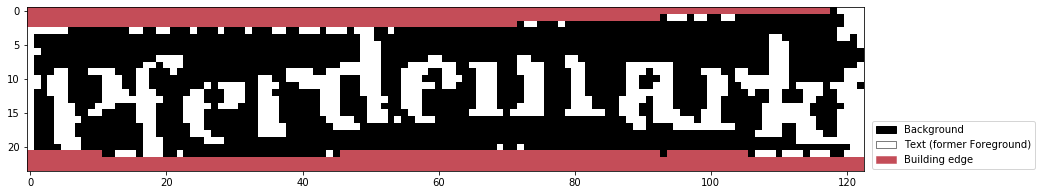

In [57]:
# plot
fig = plt.figure(figsize = (15,5)) 
ax = fig.add_subplot(111)
imshow(mask, interpolation='none', cmap=cmap)

# add legend
legend_elements = [Patch(facecolor='black', edgecolor='black', label='Background'),
                   Patch(facecolor='white', edgecolor='black', label='Text (former Foreground)', linewidth=0.5),
                   Patch(facecolor='#C44D58', edgecolor='#C44D58', label='Building edge', linewidth=0.5)
                  ]
ax.legend(handles=legend_elements, loc=(1.01,0.01))

plt.show()

In [58]:
# 5) if there are rows at the upper/lower border of the image which already contain '2's
# and/or there are still rows above/below which contain '1's:
# convert those '1's also to '2's

for rowindex, row in enumerate(mask):
    
    # lower border
    if rowindex > (len(mask)-4):
                
        # if there are rows which already have '2's (and also other values)...
        if 2 in row:
            print("row", rowindex, ": case 1 applies")
            # ...convert all remaining '1's to '2's
            mask[rowindex][mask[rowindex] == 1] = 2
            
        # if there are rows NOT containing '2's below rows which do contain '2's:
        if 2 in mask[rowindex-1] and 1 in mask[rowindex]:
            print("row", rowindex, ": case 2 applies")
            # also convert the '1's in these rows to '2's
            mask[rowindex][mask[rowindex] == 1] = 2
        
    # upper border
    if rowindex < 4:
                
        # if there are rows which already have '2's (and also other values)...
        if 2 in row:
            print("row", rowindex, ": case 1 applies")
            # ...convert all remaining '1's to '2's
            mask[rowindex][mask[rowindex] == 1] = 2
            
        # if there are rows NOT containing '2's above rows which do contain '2's:
        if 2 in mask[rowindex+1] and 1 in mask[rowindex]:
            print("row", rowindex, ": case 2 applies")
            # also convert the '1's in these rows to '2's
            mask[rowindex][mask[rowindex] == 1] = 2    

row 0 : case 1 applies
row 1 : case 1 applies
row 2 : case 1 applies
row 21 : case 1 applies
row 22 : case 1 applies
row 23 : case 1 applies


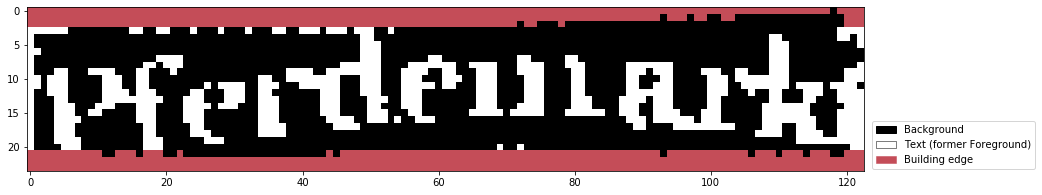

In [59]:
# plot
fig = plt.figure(figsize = (15,5)) 
ax = fig.add_subplot(111)
imshow(mask, interpolation='none', cmap=cmap)

# add legend
legend_elements = [Patch(facecolor='black', edgecolor='black', label='Background'),
                   Patch(facecolor='white', edgecolor='black', label='Text (former Foreground)', linewidth=0.5),
                   Patch(facecolor='#C44D58', edgecolor='#C44D58', label='Building edge', linewidth=0.5)
                  ]
ax.legend(handles=legend_elements, loc=(1.01,0.01))

plt.show()

### 2.1.3) Export file

In [60]:
# Covert numpy array to image 
maskpng = Image.fromarray(mask)
maskname = outfolder_1 + '_Mask.png'
imsave(outfolder + '/' + maskname, maskpng)

C:\Users\schlegel\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


# 3) Plot
Original - Three-class mask

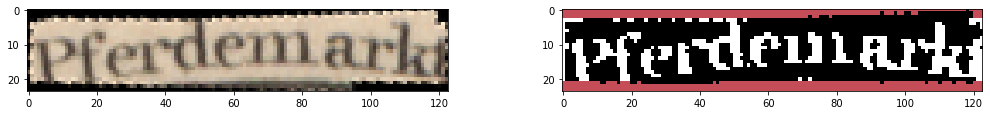

In [61]:
rgb_cv2 = cv2.imread(path+inputname)
fig = plt.figure(figsize=(15,3))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(cv2.cvtColor(rgb_cv2, cv2.COLOR_BGR2RGB))

ax2 = fig.add_subplot(2,2,2)
ax2.imshow(mask, interpolation='none', cmap=cmap)

fig.tight_layout()

# 4) Create a new Bounding box polygon excluding bulding edges

In [62]:
# make a 3 channel image from the mask so that we can bring it together with the 3 channel rgb image
mask_3d = np.stack((mask,mask,mask),axis=2) # 3 channel mask

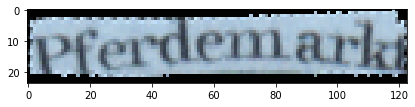

In [63]:
masked_arr = np.where(mask_3d!=2, rgb_cv2, mask_3d)

# plot
fig = plt.figure(figsize=(15,3))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(masked_arr)

## 4.1) Create a new mask for the new Bounding box

In [64]:
mask_bb_arr = mask.copy()
for row in mask_bb_arr:
    for index, value in enumerate(row):
        if value == 0 or value == 1:
            row[index] = 1
        if value == 2:
            row[index] = 0

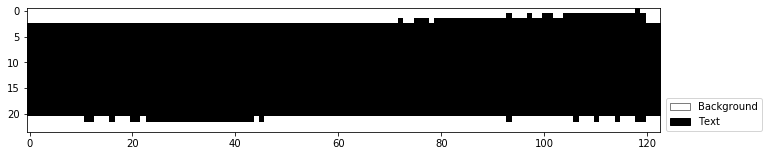

In [71]:
# plot
cmap = ListedColormap(['white','black'])
fig = plt.figure(figsize=(25,5))
ax = fig.add_subplot(2,2,1)
ax.imshow(mask_bb_arr, cmap=cmap)

# add legend
legend_elements = [Patch(facecolor='white', edgecolor='black', label='Background', linewidth=0.5),
                   Patch(facecolor='black', edgecolor='black', label='Text')
                  ]
ax.legend(handles=legend_elements, loc=(1.01,0.01))

plt.show()

In [72]:
# export to tif file
imsave(outfolder + '/' + outfolder_1+'_withoutgeoreference.tif', masked_arr)
imsave(outfolder + '/' + outfolder_1+'_Mask_BB.tif', mask_bb_arr)

C:\Users\schlegel\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
C:\Users\schlegel\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


As GDAL flips the output upside down, a worldfile has to be generated.

In [34]:
# open file
masked_arr_ng = gdal.Open(outfolder + '/' + outfolder_1+'_withoutgeoreference.tif', gdal.GA_Update)

# get the GeoTransform as a tuple
gt = masked_arr_ng.GetGeoTransform()

# change gt[5] to negative while flipping the image
gt_new = (gt[0], gt[1], gt[2], gt[3], gt[4], -1 * gt[5])

# set the new GeoTransform, effectively flipping the image
masked_arr_ng.SetGeoTransform(gt_new)

srcband = masked_arr_ng.GetRasterBand(1)

In [35]:
# Path to the generated mask layer
mask_ds = gdal.Open(outfolder + '/' + outfolder_1+"_Mask_BB.tif")
maskband = mask_ds.GetRasterBand(1)

In [36]:
# create output datasource
dst_layername = outfolder + '/' + outfolder_1+'_mask_BB.shp'
drv = ogr.GetDriverByName('ESRI Shapefile')
if os.path.exists(dst_layername):    
    drv.DeleteDataSource(dst_layername)
dst_ds = drv.CreateDataSource(dst_layername)
dst_layer = dst_ds.CreateLayer(dst_layername, geom_type=ogr.wkbPolygon)

# Polygonize with the mask
# source: https://newbedev.com/excluding-extent-when-polygonizing-raster-file-using-python
gdal.Polygonize(srcband, maskband, dst_layer, -1, [], callback=None) 
dst_ds.Destroy()
src_ds=None

### 4.1.1 Plot
Input - Bounding Box Mask

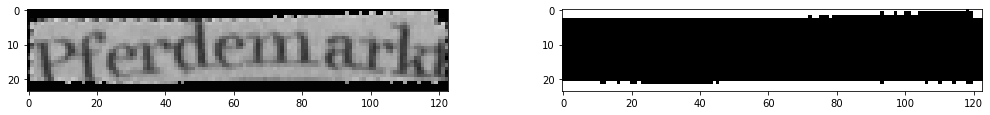

In [37]:
# maskband
ds = mask_ds.ReadAsArray()

# srcband
ds_src = srcband.ReadAsArray()

fig = plt.figure(figsize=(15,3))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(cv2.cvtColor(ds_src, cv2.COLOR_BGR2RGB))

ax2 = fig.add_subplot(2,2,2)
ax2.imshow(ds, cmap=cmap)

fig.tight_layout()

## 4.2) Create vector file from bounding box mask

In [38]:
newbb = gpd.read_file(dst_layername)
newbb.crs = "EPSG:4326" # define WGS84 as CRS

In [39]:
# dissolve individual polygons into one
newbb['diss'] = 0
newbb_dissolved = newbb.dissolve(by='diss')

In [40]:
# make a copy
newbb_dissolved_copy = newbb_dissolved.copy()

### 4.2.1) Rotate and move back to its origin position

**<span style="color:red">In the following cell, we have to check manually if the 2nd *shapely.affinity.rotate* function by 180° is necessary</span>**

In [41]:
# move origin of *newbb_dissolved* to the one of the input bb (ulx, uly)

# if it is a rotated input
if ulx == 0 and uly == 0:
    
    # extract id number
    nums = re.findall(r'(\d+(?:\.\d+)?)', outfolder)
    num_id = int(nums[0])
    
    boundingboxes = gpd.read_file("data/input/improved_boundingboxes_strabo_wgs84.shp")
    boundingboxes = boundingboxes.sort_values(by=['id'])
    boundingbox = boundingboxes.loc[boundingboxes['id'] == num_id]
       
    # 1) rotate
    angle = boundingbox["inclinatio"]
    newbb_dissolved["geometry"] = newbb_dissolved["geometry"].apply(shapely.affinity.rotate, angle=angle*(-1), origin='centroid', use_radians=False)
    newbb_dissolved["geometry"] = newbb_dissolved["geometry"].apply(shapely.affinity.rotate, angle=180, origin='centroid', use_radians=False)
        
    # 2) move
    newbb_dissolved["geometry"] = newbb_dissolved["geometry"].apply(shapely.affinity.translate, xoff=float(centroidx)-newbb_dissolved_copy.centroid.x[0], yoff=float(centroidy)-newbb_dissolved_copy.centroid.y[0])

# if the input is not rotated
else:
    
    newbb_dissolved["geometry"] = newbb_dissolved["geometry"].apply(shapely.affinity.translate, xoff=ulx, yoff=uly)

### 4.2.2) Dissolve mask
and remove small areas (originally scattered pixels) within *newbb_dissolved*. The output will be one single polygon afterwards.

<img src="figures/Clutter_BB.png" width="450" align="left"/>
<img src="figures/Clutter_BB_dissolved.png" width="450"/>

In [42]:
# dissolve
exploded = newbb_dissolved.explode()
exploded["area"] = exploded['geometry'].area

# remove small areas
filteroutsmallareas = exploded.area >= 11
newbb_expl = exploded.loc[filteroutsmallareas]

### 4.2.3) Export updated Bounding box polygon

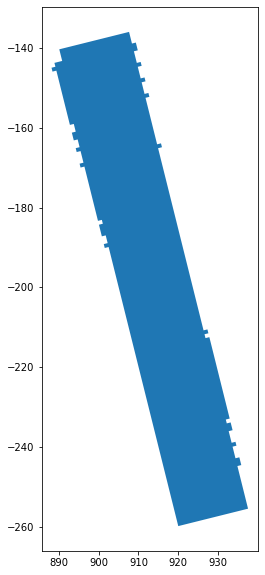

In [43]:
# plot
newbb_expl.plot(figsize=(5,10))

In [44]:
newbb_expl.to_file(outfolder + "/" + outfolder_1 + "_BB_onlyText.shp")